In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint
from tqdm.notebook import tqdm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from numpy import sqrt, std
from dotenv import load_dotenv

load_dotenv()

# For tracking through filtering process
def report_ticker_num(filtered_df):
    print(f"Universe ticker count: {len(filtered_df.columns.get_level_values(0).unique())}")

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from src.utils.visuals import mean_rev_assess_plot, mean_rev_zoom_comp_plot
from src.data_handler import DataHandler, align_data
import nest_asyncio
nest_asyncio.apply()

## **Data Acquisition & Filtering**

To ensure reproducibility, I began by pre-loading a list of **5,151 common stock tickers** into `data/common_stock_tickers.csv`, filtered directly from Polygon’s asset database using their API. Only tickers classified as *common stocks* were retained.

To construct a high-quality dataset suitable for pair selection, model training, and backtesting, I applied a multi-step filtering process grounded in best practices from academic and industry sources:

- **Penny Stock Exclusion**:  
  Penny stocks are notoriously volatile and thinly traded, which undermines the assumptions and stability required for statistical arbitrage. Following the **SEC's official definition**, I excluded any stock with an average price below **\$5**.

- **Data Availability Threshold**:  
  Stocks with incomplete historical data are suboptimal for modeling, as missing bars lead to biased training signals and noisy residuals. I retained only those tickers that had data available for at least **90% of the maximum possible bars** over the 2-year period. This ensures robustness and consistency across our universe.

- **Liquidity Filter via Volume**:  
  To ensure that selected pairs are tradeable in realistic conditions, I filtered out illiquid stocks by calculating the **average daily trading volume** for each ticker and excluding those below the **50th percentile**. This percentile-based threshold is recommended in academic material on statistical arbitrage to balance liquidity with breadth.  
  _Source: [Xuanchi Zhu – Examining Pairs Trading Profitability (2024)](https://economics.yale.edu/sites/default/files/2024-05/Zhu_Pairs_Trading.pdf)_

Following this pipeline, **412 high-quality tickers** remained. These tickers will form the candidate universe for pair selection and model training.

All OHLCV minute-bar data was downloaded for a **3-year period (2022–2024)**. This duration strikes a balance between sample size and computational manageability, and is aligned with conventions cited in practitioner circles.

Data acquisition, processing, and validation were conducted via the `src/data_handler.py` module. The module handles:
- Fault-tolerant API fetching
- Robust asynchronous parallelization
- Modularity and logging for maintainability
- Cleaning anomalies such as extreme price/volume spikes and data gaps

A final key cleaning step involved dropping the **first and last 30 minutes of each trading day**, which are known for hightened volatility and irregularities in stock return patterns.  
_Source: [Baltussen, G., Da, Z., & Soebhag, A. (2025) – End-of-Day Reversal](https://www3.nd.edu/~zda/EOD.pdf)_

After cleaning, I split the data into various chronological time segments for modeling:  
**20 months** for training, **8 months** for validation, a combination of the **28 train & val months** for training models that don't require validation phases, and **8 months** for testing / simulation. These splits follow common practice in model development. For my own later use, I saved the full universe and each split in the <code>data/</code> directory in compressed Parquet format.

This rigorous filtering, cleaning, and structuring process ensures a stable and realistic data foundation for statistical arbitrage model development and evaluation.

In [2]:
# Construct relative path to the CSV
data_dir = os.path.abspath(os.path.join('..', 'data'))
ticker_csv = os.path.join(data_dir, 'common_stock_tickers.csv')
tickers = pd.read_csv(ticker_csv)['ticker'].tolist()

# Load unaligned raw data
secret = os.getenv("POLYGON_API_KEY")
handler = DataHandler(tickers=tickers, api_key=secret, max_concurrent_requests=15)
raw_df = handler.fetch_all_to_df(start_date="2022-01-01", end_date="2024-12-31")

# For tracking through filtering process
def report_ticker_num(filtered_df):
    print(f"Universe ticker count: {len(filtered_df.columns.get_level_values(0).unique())}")

Fetching all tickers: 100%|██████████| 5151/5151 [1:08:11<00:00,  1.26it/s]


In [3]:
# Filter out penny stocks as they are undesirably volatile for our strategy
threshold_price = 5
mean_close = raw_df.xs('close', level=1, axis=1).mean()
valid_tickers_price = mean_close[mean_close >= threshold_price].index.tolist()
filtered_df = raw_df[valid_tickers_price]

report_ticker_num(filtered_df)

Universe ticker count: 4122


In [4]:
# Filter out tickers with low data availability (<90% of max)
bar_counts = {ticker: df.dropna().shape[0] for ticker, df in filtered_df.items()}
max_count = max(bar_counts.values())
min_required = 0.9 * max_count
filtered_dict = {ticker: df for ticker, df in filtered_df.items() if bar_counts[ticker] >= min_required}

# Recombine filtered dict into a DataFrame
filtered_df = pd.concat(filtered_dict.values(), axis=1, keys=filtered_dict.keys())
report_ticker_num(filtered_df)

Universe ticker count: 824


In [5]:
# Filter by 50th percentile in daily average volume
# to ensure stocks are highly liquid
avg_volumes = filtered_df.xs('volume', level=1, axis=1).mean()
median_volume = avg_volumes.median()
valid_tickers_volume = avg_volumes[avg_volumes >= median_volume].index.tolist()
filtered_df = filtered_df[valid_tickers_volume]

report_ticker_num(filtered_df)

Universe ticker count: 412


In [6]:
# Align and print final result
aligned_df = align_data(filtered_df)

report_ticker_num(filtered_df)
print(aligned_df.shape)
display(aligned_df.head())

Universe ticker count: 412
(248359, 2060)


CSCO                                      KDP         \
                       open   high      low   close   volume    open   high   
datetime                                                                      
2022-01-03 10:00:00  62.840  62.85  62.7800  62.845  35553.0  36.340  36.34   
2022-01-03 10:01:00  62.850  62.87  62.7750  62.780  51468.0  36.310  36.31   
2022-01-03 10:02:00  62.785  62.80  62.7300  62.800  61573.0  36.280  36.30   
2022-01-03 10:03:00  62.800  62.84  62.7801  62.795  50289.0  36.295  36.32   
2022-01-03 10:04:00  62.795  62.84  62.7400  62.740  40088.0  36.290  36.30   

                                             ...       JPM            \
                       low   close   volume  ...      open      high   
datetime                                     ...                       
2022-01-03 10:00:00  36.33  36.330    912.0  ...  161.0400  161.4200   
2022-01-03 10:01:00  36.26  36.260   1658.0  ...  161.3900  161.4000   
2022-01-03 10:02:00  36.25  36.295  26592.0  ...  161.2900  161.3600   
2022-01-03 10:03:00  36.29  36.290   7845.0  ...  161.0727  161.0727   
2022-01-03 10:04:00  36.28  36.300   3213.0  ...  160.8900  161.0600   

                                                   CRWD                    \
                          low   close   volume     open      high     low   
datetime                                                                    
2022-01-03 10:00:00  161.0300  161.42  88452.0  194.755  195.5200  194.51   
2022-01-03 10:01:00  161.2600  161.29  44805.0  195.380  196.5618  195.12   
2022-01-03 10:02:00  161.0500  161.09  44053.0  196.215  196.4640  195.51   
2022-01-03 10:03:00  160.8720  160.89  40753.0  195.900  195.9500  195.25   
2022-01-03 10:04:00  160.8734  160.96  36798.0  195.280  195.4700  195.04   

                                       
                       close   volume  
datetime                               
2022-01-03 10:00:00  195.315  33828.0  
2022-01-03 10:01:00  196.300  29833.0  
2022-01-03 10:02:00  195.710  45482.0  
2022-01-03 10:03:00  195.330  58710.0  
2022-01-03 10:04:00  195.180  64054.0  

[5 rows x 2060 columns]

In [7]:
# Save data (and my train/val/test splits) for later use

# Ensure datetime index is sorted
aligned_df = aligned_df.sort_index()

train_end = "2023-08-31"
val_end = "2024-04-30"
train_df = aligned_df.loc[:train_end]
val_df = aligned_df.loc[train_end:val_end]
full_train_df = aligned_df.loc[:val_end]
test_df = aligned_df.loc[val_end:]

# Save all to compressed Parquet
aligned_df.to_parquet(os.path.join(data_dir, "universe_full.parquet"), compression="brotli")
train_df.to_parquet(os.path.join(data_dir, "train.parquet"), compression="brotli")
val_df.to_parquet(os.path.join(data_dir, "val.parquet"), compression="brotli")
full_train_df.to_parquet(os.path.join(data_dir, "full_train.parquet"), compression="brotli")
test_df.to_parquet(os.path.join(data_dir, "test.parquet"), compression="brotli")

## **Pair Research Pipeline Overview**

This notebook is dedicated to the **systematic discovery and filtering of candidate trading pairs** for a mean-reversion strategy based on statistical arbitrage. The broader project centers around constructing a robust pipeline for identifying equity pairs that exhibit stable, cointegrated relationships with strong mean-reverting behavior — a critical component for building a profitable long/short trading strategy.

We begin this notebook by focusing on **pair generation and correlation filtering**, which forms the foundation of the pipeline. Using minute-bar historical price data, we construct all possible unique ticker pairs from a universe of liquid equities. From this superset, we apply a correlation filter to retain only those pairs with sufficiently strong linear relationships in price movement. While correlation alone is not enough to infer long-term equilibrium, it serves as a valuable first-pass filter to reduce the candidate space and computational burden in downstream testing.

The subsequent stages in the notebook will build on this reduced universe, applying statistical tests and modeling techniques to further refine the selection of viable trading pairs.

In [8]:
TOP_N = 1000

# Load train data
train_df = pd.read_parquet("../data/full_train.parquet")

# Extract close prices: columns = tickers, rows = minute timestamps
close_px = train_df.xs('close', axis=1, level=1)

# Compute minute-level log returns
log_returns = np.log(close_px / close_px.shift(1))

# Compute pairwise correlation matrix
corr_matrix = log_returns.corr()

# Build list of (ticker_A, ticker_B, correlation)
pairs = []
for i, j in combinations(corr_matrix.columns, 2):
    corr = corr_matrix.loc[i, j]
    pairs.append((i, j, corr))

# Sort and take top-N by absolute correlation
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
top_pairs_df = pd.DataFrame(pairs_sorted[:TOP_N], columns=["ticker1", "ticker2", "correlation"])

# Visualize
display(top_pairs_df.head())

,ticker1,ticker2,correlation
0,GOOG,GOOGL,0.966453
1,UA,UAA,0.896318
2,DAL,UAL,0.862744
3,PAA,PAGP,0.854869
4,SLB,HAL,0.853704


---
### **Cointegration Filtering via Engle-Granger Test**

Having reduced the universe of potential pairs through correlation screening, we now proceed to identify those with a **long-term equilibrium relationship** by applying the **Engle-Granger two-step cointegration test**.

While correlation captures short-term co-movement, it does not guarantee that the spread between two assets remains stable over time. **Cointegration** addresses this limitation by testing whether a linear combination of two non-stationary price series yields a **stationary residual**, implying the existence of a statistically mean-reverting spread.

For each candidate pair, we:

1. Regress the price series of one asset on the other using Ordinary Least Squares (OLS).
2. Perform the **Augmented Dickey-Fuller (ADF) test** on the resulting residuals to check for stationarity.

Only pairs whose residuals reject the unit root null hypothesis (i.e. pass the ADF test at a statistically significant level) are retained. This step ensures that we move forward with pairs whose spread dynamics are not just correlated, but also statistically tethered over time, which a critical characteristic for mean-reversion trading strategies.

> **Note**: I use log price series to ensure consistent scaling and more stable regression residuals. *(More on the benefits of log prices in the next section)*


In [ ]:
# Parameters
COINT_P_THRESHOLD = 0.05  # Common threshold for cointegration significance

# Initialize list to store cointegrated pairs and their p-values
coint_results = []

# Loop through top N pairs and test for cointegration
for _, row in tqdm(top_pairs_df.iterrows(), total=len(top_pairs_df), desc="Cointegration Filtering", file=sys.stdout):
    t1, t2 = row['ticker1'], row['ticker2']
    s1 = np.log(close_px[t1])
    s2 = np.log(close_px[t2])

    # Drop rows with missing data for this pair
    pair_df = pd.concat([s1, s2], axis=1).dropna()
    
    # Perform Engle-Granger cointegration test
    _, pval, _ = coint(pair_df.iloc[:, 0], pair_df.iloc[:, 1], maxlag=8)
    
    if pval < COINT_P_THRESHOLD:
        coint_results.append({
            'ticker1': t1,
            'ticker2': t2,
            'correlation': row['correlation'],
            'coint_pval': pval
        })

# Create filtered dataframe
coint_pairs_df = pd.DataFrame(coint_results)

# Sort by p-value ascending
coint_pairs_df = coint_pairs_df.sort_values("coint_pval").reset_index(drop=True)

# Print summary
print(f"Number of cointegrated pairs found: {len(coint_pairs_df)}")
display(coint_pairs_df.head())


Cointegration Filtering: 100%|██████████| 1000/1000 [14:23<00:00,  1.16it/s]

Number of cointegrated pairs found: 161


,ticker1,ticker2,correlation,coint_pval
0,GOOG,GOOGL,0.966453,3.745271e-08
1,MOS,NTR,0.768793,2.186562e-05
2,SYF,WFC,0.654162,2.193357e-05
3,HWM,IR,0.587788,1.289702e-04
4,PAA,PAGP,0.854869,1.590224e-04


---
### **Spread Construction and Rolling Hedge Ratio Estimation**

For each cointegrated pair, we construct the **spread** - the stationary linear combination of the two asset prices - to be used in downstream **mean reversion assessments**.

To ensure stability, scale-independence, and consistency with the theoretical foundations of cointegration and mean-reversion modeling, I work with **log-transformed prices**. This transformation converts multiplicative price relationships into additive ones, which:

- Simplifies linear modeling (e.g., OLS regression for hedge ratio estimation)
- Makes the hedge ratio $\beta$ easier to interpret in terms of how one asset moves in relation to the other
- Improves the likelihood of obtaining stationary spread series suitable for OU modeling

The spread is therefore defined as:

$$
\text{Spread}_t = P^{(1)}_t - \beta \cdot P^{(2)}_t
$$

where $\beta$ is the hedge ratio estimated via full-sample OLS regression.

In addition to this static spread, we compute the **rolling hedge ratio** using a moving OLS window to capture the **time-varying behavior of the relationship** between the assets. This rolling beta series will be critical for our later step on **beta stability filtering**, which aims to discard pairs whose interdependence is not consistent over time - a key risk in deploying mean-reversion strategies.

This spread series becomes the core input for all subsequent assessments of mean-reverting behavior.

In [ ]:
# Window for rolling beta
MEAN_ROLLING_WINDOW = 330 * 5 * 8  # 8 weeks (13,200 bars)

# Initialize list to hold spread information
spread_data = []

# Iterate over cointegrated pairs
for _, row in tqdm(coint_pairs_df.iterrows(), total=len(coint_pairs_df), desc="Constructing Spreads", file=sys.stdout):
    t1, t2 = row['ticker1'], row['ticker2']
    s1 = np.log(close_px[t1])
    s2 = np.log(close_px[t2])
    
    # Drop missing values for this pair
    pair_df = pd.concat([s1, s2], axis=1).dropna()
    pair_df.columns = ['s1', 's2']

    # Estimate hedge ratio using full sample OLS
    X = sm.add_constant(pair_df['s2'])
    model = sm.OLS(pair_df['s1'], X).fit()
    hedge_ratio = model.params['s2']

    # Construct spread: s1 - beta * s2
    pair_df['spread'] = pair_df['s1'] - hedge_ratio * pair_df['s2']

    # Vectorized rolling beta calculation
    s1_roll_mean = pair_df['s1'].rolling(window=MEAN_ROLLING_WINDOW).mean()
    s2_roll_mean = pair_df['s2'].rolling(window=MEAN_ROLLING_WINDOW).mean()

    cov = (pair_df['s1'] * pair_df['s2']).rolling(window=MEAN_ROLLING_WINDOW).mean() - s1_roll_mean * s2_roll_mean
    var = pair_df['s2'].rolling(window=MEAN_ROLLING_WINDOW).var()

    pair_df['rolling_beta'] = cov / var

    # Store results for this pair
    spread_data.append({
        'ticker1': t1,
        'ticker2': t2,
        'correlation': row['correlation'],
        'coint_pval': row['coint_pval'],
        'hedge_ratio': hedge_ratio,
        'spread_series': pair_df['spread'],
        'rolling_beta_series': pair_df['rolling_beta']
    })

# Convert to DataFrame for future filtering
spread_pairs_df = pd.DataFrame(spread_data)

# Sanity check
print(f"Constructed spreads for {len(spread_pairs_df)} pairs.")
display(spread_pairs_df.head())

Constructing Spreads: 100%|██████████| 161/161 [00:10<00:00, 15.58it/s]

Constructed spreads for 161 pairs.


,ticker1,ticker2,correlation,coint_pval,hedge_ratio,spread_series,rolling_beta_series
0,GOOG,GOOGL,0.966453,3.745271e-08,1.004352,datetime 2022-01-03 10:00:00 -0.021921 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...
1,MOS,NTR,0.768793,2.186562e-05,1.039775,datetime 2022-01-03 10:00:00 -0.802406 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...
2,SYF,WFC,0.654162,2.193357e-05,1.024615,datetime 2022-01-03 10:00:00 -0.152018 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...
3,HWM,IR,0.587788,1.289702e-04,0.951975,datetime 2022-01-03 10:00:00 -0.438589 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...
4,PAA,PAGP,0.854869,1.590224e-04,1.018639,datetime 2022-01-03 10:00:00 -0.127535 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...


---
### **Augmented Dickey-Fuller (ADF) Test for Mean Reversion**

Having constructed the spread series for each co-integrated pair, we now assess the strength of mean reversion by applying the Augmented Dickey-Fuller (ADF) test to each spread.

The ADF test evaluates the null hypothesis that a unit root is present in the time series, implying non-stationarity. A significantly negative ADF statistic and low p-value provide statistical evidence in favor of stationarity — a desirable property for mean-reverting strategies.

Only pairs with p-values below a defined threshold (0.05) are retained for further analysis, ensuring that selected spreads exhibit strong mean-reversion characteristics consistent with a stationary process.

In [ ]:
# Parameters
ADF_P_THRESHOLD = 0.05

adf_results = []

# Iterate over pairs and test their spreads
for _, row in tqdm(spread_pairs_df.iterrows(), total=len(spread_pairs_df), desc="ADF Test on Spreads", file=sys.stdout):
    spread = row['spread_series']
    
    # ADF test returns test_statistic, pvalue, etc.
    adf_stat, pval, _, _, _, _ = adfuller(spread, maxlag=8)

    if pval < ADF_P_THRESHOLD:
        adf_results.append({
            'ticker1': row['ticker1'],
            'ticker2': row['ticker2'],
            'correlation': row['correlation'],
            'coint_pval': row['coint_pval'],
            'hedge_ratio': row['hedge_ratio'],
            'adf_stat': adf_stat,
            'adf_pval': pval,
            'spread_series': row['spread_series'],
            'rolling_beta_series': row['rolling_beta_series']
        })

# Convert to filtered DataFrame and sort by ADF p-val
adf_pairs_df = pd.DataFrame(adf_results)
adf_pairs_df = adf_pairs_df.sort_values("adf_pval").reset_index(drop=True)

# Summary
print(f"Number of mean-reverting spreads: {len(adf_pairs_df)}")
display(adf_pairs_df.head())

ADF Test on Spreads: 100%|██████████| 161/161 [01:42<00:00,  1.57it/s]

Number of mean-reverting spreads: 161


,ticker1,ticker2,correlation,coint_pval,hedge_ratio,adf_stat,adf_pval,spread_series,rolling_beta_series
0,GOOG,GOOGL,0.966453,3.745271e-08,1.004352,-6.728322,3.345382e-09,datetime 2022-01-03 10:00:00 -0.021921 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...
1,MOS,NTR,0.768793,2.186562e-05,1.039775,-5.456879,2.569918e-06,datetime 2022-01-03 10:00:00 -0.802406 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...
2,SYF,WFC,0.654162,2.193357e-05,1.024615,-5.456194,2.578503e-06,datetime 2022-01-03 10:00:00 -0.152018 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...
3,HWM,IR,0.587788,1.289702e-04,0.951975,-5.057367,1.706703e-05,datetime 2022-01-03 10:00:00 -0.438589 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...
4,PAA,PAGP,0.854869,1.590224e-04,1.018639,-5.008195,2.137913e-05,datetime 2022-01-03 10:00:00 -0.127535 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...


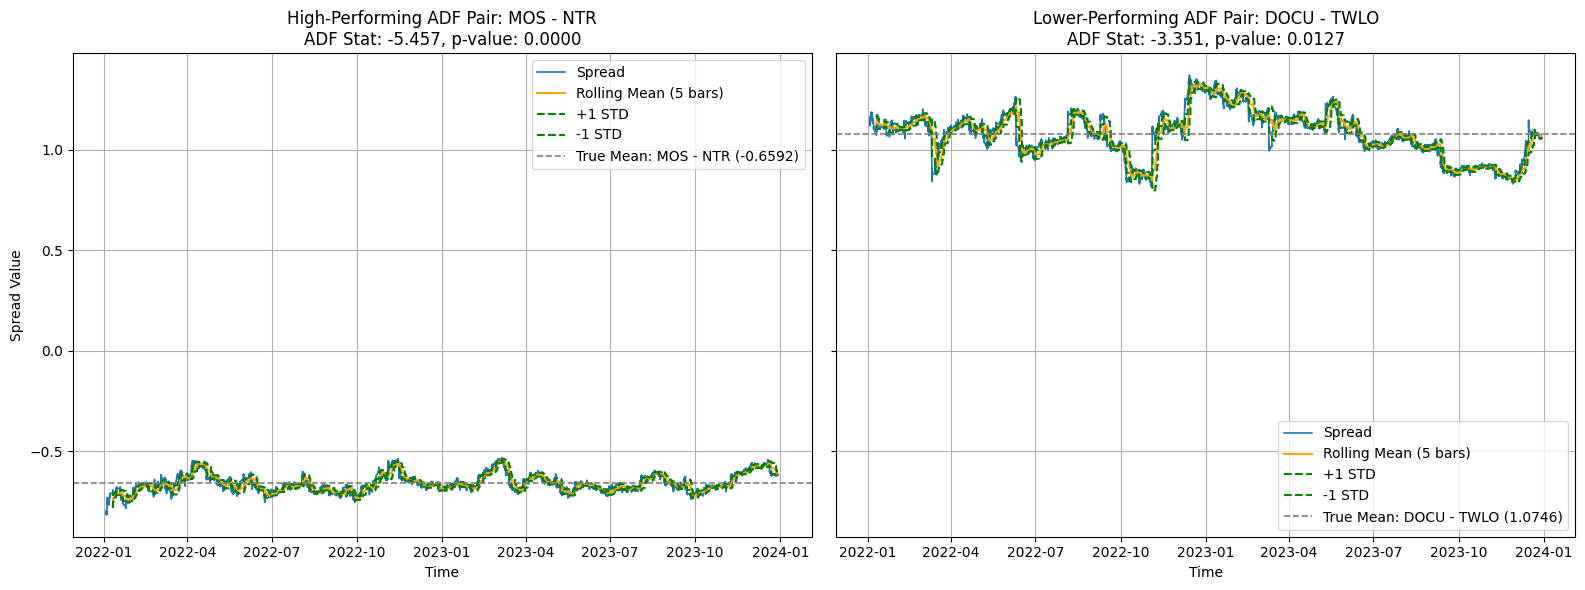

In [ ]:
# Sanity Check / Visualization

MEAN_ROLLING_WINDOW = 5  # in days
start_date = '2022-01-01'  # Define a zoom window
end_date = '2024-01-01'
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Set up subplots

mean_rev_assess_plot(
    rolling_window=MEAN_ROLLING_WINDOW,
    start_date=start_date,
    end_date=end_date,
    pairs={
        'High-Performing': adf_pairs_df.iloc[1],
        'Lower-Performing': adf_pairs_df.iloc[-4]
    },
    axes=axes,
    metric_label="ADF",
    stat_fn=lambda row: f"ADF Stat: {row['adf_stat']:.3f}, p-value: {row['adf_pval']:.4f}",
    legend_locs=['upper right', 'lower right']
)

#### ADF Test Visualization: Interpreting Spread Stationarity

The visualizations above provide a qualitative assessment of spread stationarity for two co-integrated pairs that passed the ADF test. Both pairs demonstrate mean-reverting behavior, with observable deviations around a central tendency that provide potential trading opportunities.

The left panel (**MOS - NTR**) shows a tightly oscillating spread around its rolling mean throughout time. This tight clustering is indicative of strong and persistent mean reversion - characteristics that typically lead to a lower ADF statistic and higher confidence in stationarity.

In contrast, the right panel (**DOCU - TWLO**) features wider oscillations and a more variable spread trajectory. Despite the movement, the spread continues to revert toward its mean over time. This behavior, although less robust, remains consistent with the statistical result of a stationary process.

These plots highlight the value of qualitive analysis and understanding the difference in metrics conceptually. They also show that although both pairs exhibit mean reversion and passed the test, the pair on the left is more favorable due to stronger stationarity, which explains why it performed better on the test.

---
### **Hurst Exponent Analysis and Filtering**

To further assess the strength and quality of mean-reversion in the candidate spread series, I computed the **Hurst Exponent** $H$ for each pair. The Hurst exponent is a statistical measure that quantifies the **long-term memory** or **persistence** of a time series, and is commonly used in quantitative finance to characterize the behavior of asset returns or spread processes.

The value of $H$ provides insight into the underlying dynamics of the series:

- $H < 0.5$: Anti-persistent (mean-reverting) behavior  
- $H = 0.5$: Geometric Brownian motion (memoryless random walk)  
- $H > 0.5$: Persistent (trend-following) behavior

From a trading perspective, spreads exhibiting **low Hurst exponents** are more likely to oscillate around a stable mean, making them strong candidates for mean-reversion-based strategies such as pairs trading.

The Hurst exponent is estimated by analyzing how the variability of the spread changes with time scale. Specifically, for a range of lags, we compute the standard deviation of the spread’s differences at each lag and fit a linear regression in log-log space:

$$
\log(\text{std}(\Delta X_{\text{lag}})) = H \cdot \log(\text{lag}) + \text{constant}
$$

The slope of this regression provides an estimate of the Hurst exponent $H$. This method captures the scaling behavior of the time series and is commonly used in quantitative finance to assess persistence or mean-reversion.

To retain only spreads with significant mean-reverting characteristics, I applied a conservative threshold of $H \leq 0.4$. This eliminates pairs that may satisfy cointegration or ADF tests but still exhibit excessive trend-following or noise in practice.

In [ ]:
# Set Hurst threshold
HURST_THRESHOLD = 0.4

def compute_hurst(series, max_lag=100):
    lags = np.arange(2, max_lag)
    tau = [sqrt(std(series.diff(lag).dropna(), ddof=1)) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]  # Hurst exponent

hurst_results = []

# Analyze each pair
for _, row in tqdm(adf_pairs_df.iterrows(), total=len(adf_pairs_df), desc="Hurst Filtering", file=sys.stdout):
    spread = row['spread_series']
    hurst = compute_hurst(spread)

    # Tag and store result
    row = row.copy()
    row['hurst'] = hurst
    if hurst <= HURST_THRESHOLD:  # Filter by Hurst exponent
        hurst_results.append(row)

# Create filtered DataFrame
hurst_pairs_df = pd.DataFrame(hurst_results).reset_index(drop=True)

# Summary
print(f"Number of pairs passing Hurst filter: {len(hurst_pairs_df)}")
display(hurst_pairs_df[['ticker1', 'ticker2', 'hurst']].head())


Hurst Filtering: 100%|██████████| 161/161 [01:31<00:00,  1.76it/s]

Number of pairs passing Hurst filter: 161


,ticker1,ticker2,hurst
0,GOOG,GOOGL,0.144679
1,MOS,NTR,0.240808
2,SYF,WFC,0.247220
3,HWM,IR,0.237701
4,PAA,PAGP,0.189896


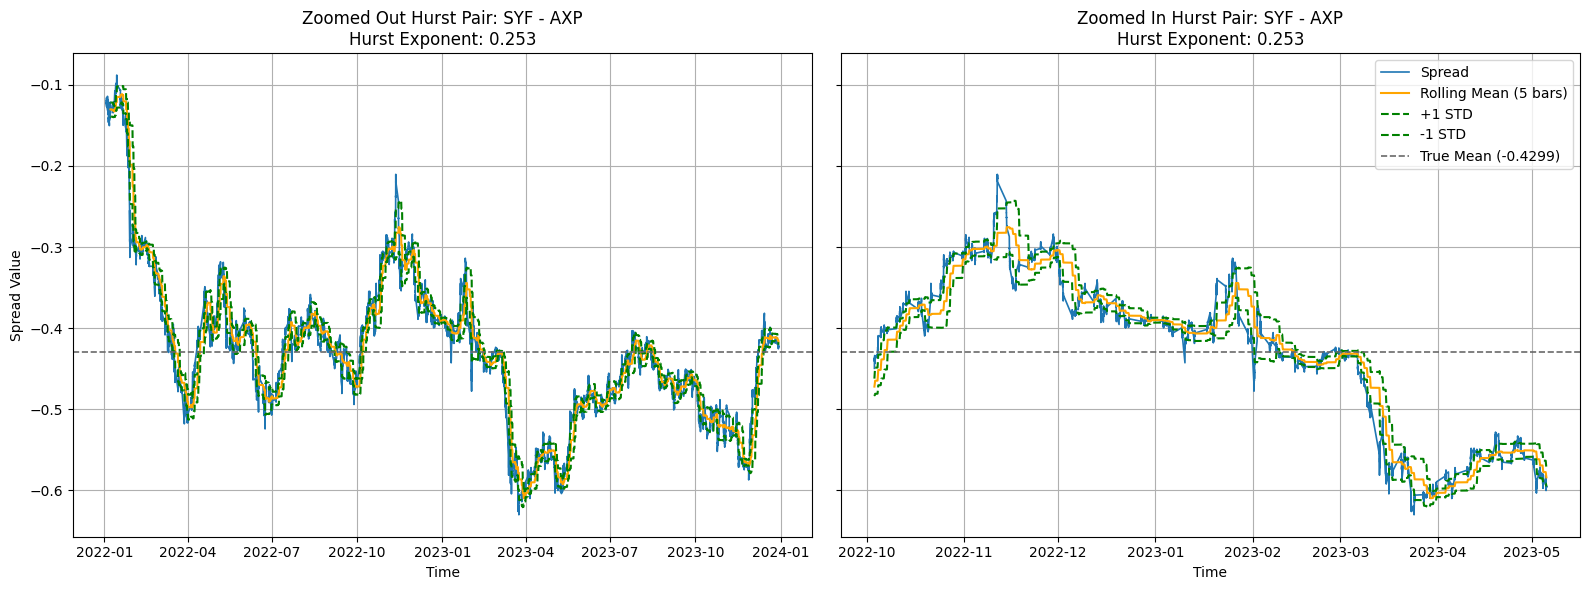

In [59]:
# Sanity Check / Visualization

low_perf_pair = hurst_pairs_df.sort_values('hurst').iloc[-1]

# Define two zoom levels
zoom_out = ("Zoomed Out", "2022-01-01", "2024-01-01")
zoom_in = ("Zoomed In", "2022-10-01", "2023-05-5")

# Call the comparison function
mean_rev_zoom_comp_plot(
    pair_row=low_perf_pair,
    zoom1=zoom_out,
    zoom2=zoom_in,
    rolling_window=5,  # days
    metric_label="Hurst",
    stat_fn=lambda row: f"Hurst Exponent: {row['hurst']:.3f}",
)

#### Hurst Spread Visualization: Analyzing Low-Performing Pair

In the visualization above we can see the spread of the lowest performing pair by Hurst Exponent (**SYF - AXP**), on zoomed out and zoomed in intervals. While mean reversion is visible, it's also clear that the movement away from the mean varies greatly, and can last for long periods of time.

While it's mean reverting characteristics were enough for the spread to pass the test, the large periods of time between mean reversions are cause for concern. As is the case in the above spread, longer periods between reversions translates to fewer opportunities to for arbitrage, and potentially more room for volatility to affect modeling capabilities and signal generation.

To address these concerns we'll analyze the mean reversion half-life and hedge-ratio volatility for all pairs.

---
### **Half-Life Analysis and Filtering**

To further refine our candidate universe of cointegrated pairs, we introduce a filter based on the **half-life of mean reversion**, a key metric in statistical arbitrage. While prior filters (e.g. ADF & Hurst exponent) confirm that the spread exhibits mean-reverting behavior, they do not inform us of **how quickly** this reversion occurs, which is a critical factor for strategy viability within a finite backtest or live trading horizon.

The **half-life** is defined as the expected number of bars it takes for a mean-reverting spread to revert halfway back to its long-run equilibrium after a deviation. Pairs with shorter half-lives tend to mean-revert more quickly, offering more frequent trading opportunities and faster capital turnover.

We estimate the half-life by fitting an **AR(1)** model to the spread series:

$$
\text{Spread}_t = \alpha + \phi \cdot \text{Spread}_{t-1} + \epsilon_t
$$

From the estimated autoregressive coefficient $\phi$, the half-life is derived as:

$$
\text{Half-life} = -\frac{\ln(2)}{\ln(|\phi|)}
$$

This formula assumes $0 < |\phi| < 1$, the stationary region for the AR(1) process. The result gives us a bar-level estimate of reversion speed, which we convert to trading days for interpretability.

We will filter out pairs with excessively long half-lives, as they would yield too few actionable signals in our 8-month backtest window.

In [ ]:
half_life_results = []

for _, row in tqdm(adf_pairs_df.iterrows(), total=len(adf_pairs_df), desc="Computing Half-Life", file=sys.stdout):
    spread = pd.Series(row['spread_series']).dropna()

    # Align lagged and current spread
    spread = pd.Series(row['spread_series']).dropna()

    spread_lag = spread.shift(1).dropna()
    spread_curr = spread.loc[spread_lag.index]

    # Fit AR(1): spread_t = α + φ * spread_{t-1} + ε_t
    X = sm.add_constant(spread_lag.values)
    y = spread_curr.values
    model = sm.OLS(y, X).fit()
    phi = model.params[1]

    if 0 < abs(phi) < 1:
        half_life = -np.log(2) / np.log(abs(phi))
    else:
        half_life = np.nan

    half_life_results.append({
        'ticker1': row['ticker1'],
        'ticker2': row['ticker2'],
        'half_life': half_life,
    })

Computing Half-Life: 100%|██████████| 161/161 [00:08<00:00, 17.91it/s]


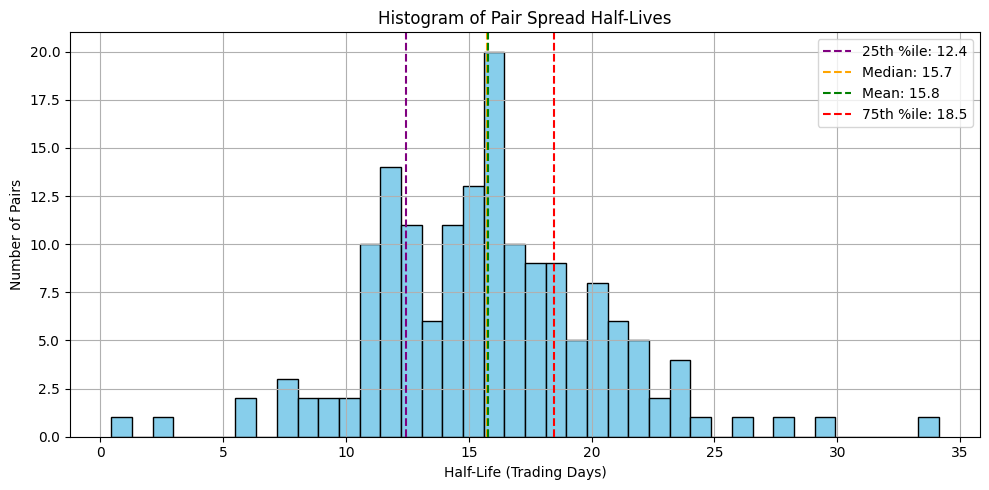

Summary statistics for Half-Life (in trading days):
count    161.000000
mean      15.769959
std        4.701881
min        0.453447
25%       12.439090
50%       15.726227
75%       18.488628
max       34.124350
Name: half_life_days, dtype: float64


In [16]:
# Convert half-life from bars to trading days
bars_per_day = 330
half_life_df = pd.DataFrame(half_life_results).dropna().copy()
half_life_df['half_life_days'] = half_life_df['half_life'] / bars_per_day

# Calculate overlay statistics
hl_25 = half_life_df['half_life_days'].quantile(0.25)
hl_mean = half_life_df['half_life_days'].mean()
hl_median = half_life_df['half_life_days'].median()
hl_75th = half_life_df['half_life_days'].quantile(0.75)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(half_life_df['half_life_days'], bins=40, color='skyblue', edgecolor='black')
plt.axvline(hl_25, color='purple', linestyle='--', label=f'25th %ile: {hl_25:.1f}')
plt.axvline(hl_median, color='orange', linestyle='--', label=f'Median: {hl_median:.1f}')
plt.axvline(hl_mean, color='green', linestyle='--', label=f'Mean: {hl_mean:.1f}')
plt.axvline(hl_75th, color='red', linestyle='--', label=f'75th %ile: {hl_75th:.1f}')
plt.title("Histogram of Pair Spread Half-Lives")
plt.xlabel("Half-Life (Trading Days)")
plt.ylabel("Number of Pairs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary statistics for Half-Life (in trading days):")
print(half_life_df['half_life_days'].describe())

#### Half-Life Threshold Selection

The distribution of spread half-lives across all candidate pairs is shown above. Most half-lives cluster between 10 and 20 trading days, with a slight right skew. The **median** half-life is approximately **15.72 days**, while the **mean** is **15.76 days**, both aligning closely around the 3-week mark.

To filter out slower mean-reverting pairs, I use the **median half-life (15.7 trading days)** as a practical threshold. This strikes a balance between excluding pairs with excessively slow convergence and retaining a broad yet statistically reliable set of candidates.

In [ ]:
# Compute median threshold
hl_median = half_life_df['half_life_days'].median()

# Merge with spread_pairs_df to add half_life_days to data
total_half_life_pairs_df = pd.merge(
    spread_pairs_df,
    half_life_df[['ticker1', 'ticker2', 'half_life_days']],
    on=['ticker1', 'ticker2'],
    how='inner'
)

# Filter half-life DataFrame
filtered_pairs_df = total_half_life_pairs_df[total_half_life_pairs_df['half_life_days'] < hl_median]

print(f"Selected {len(filtered_pairs_df)} pairs with fast-reverting half-lives (< {hl_median:.2f} trading days)")
display(filtered_pairs_df[['ticker1', 'ticker2', 'half_life_days']].head())

Selected 80 pairs with fast-reverting half-lives (< 15.73 trading days)


,ticker1,ticker2,correlation,coint_pval,hedge_ratio,spread_series,rolling_beta_series,rolling_beta_std,half_life_days
0,GOOG,GOOGL,0.966453,3.745271e-08,1.004352,datetime 2022-01-03 10:00:00 -0.021921 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...,0.017280,0.453447
1,MOS,NTR,0.768793,2.186562e-05,1.039775,datetime 2022-01-03 10:00:00 -0.802406 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...,0.330551,6.301528
2,SYF,WFC,0.654162,2.193357e-05,1.024615,datetime 2022-01-03 10:00:00 -0.152018 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...,0.398233,8.007512
3,HWM,IR,0.587788,1.289702e-04,0.951975,datetime 2022-01-03 10:00:00 -0.438589 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...,0.351356,12.227599
4,PAA,PAGP,0.854869,1.590224e-04,1.018639,datetime 2022-01-03 10:00:00 -0.127535 2022-...,datetime 2022-01-03 10:00:00 NaN 2022-...,0.088261,2.407088


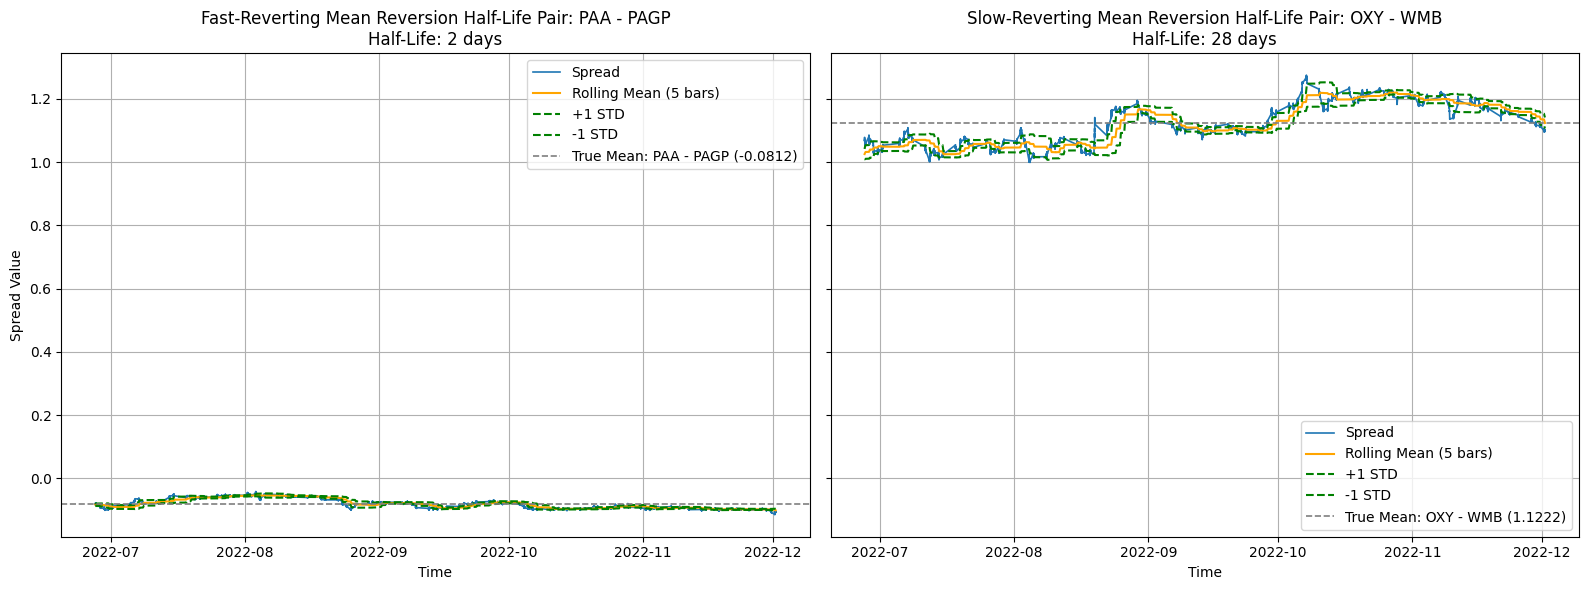

In [ ]:
start_date = '2022-06-25'
end_date = '2022-12-01'

# Sort filtered pairs by half-life
sorted_pairs_df = total_half_life_pairs_df.sort_values(by='half_life_days').reset_index(drop=True)

# Select best (shortest half-life) and worst (longest half-life)
best_pair_row = sorted_pairs_df.iloc[1]
worst_pair_row = sorted_pairs_df.iloc[-3]

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for comparison
mean_rev_assess_plot(
    rolling_window=MEAN_ROLLING_WINDOW,
    start_date=start_date,
    end_date=end_date,
    pairs={
        'Fast-Reverting': best_pair_row,
        'Slow-Reverting': worst_pair_row
    },
    axes=axes,
    metric_label="Mean Reversion Half-Life",
    stat_fn=lambda row: f"Half-Life: {row['half_life_days']:.0f} days",
    legend_locs=['upper right', 'lower right']
)


#### **Half-Life Visualization: Fast-Reverting vs. Slow-Reverting Pairs**

The plots above illustrate the practical difference in mean-reversion speed between a **fast-reverting** pair (**PAA - PAGP**, left) and a **slow-reverting** pair (**OXY - WMB**, right), as measured by their estimated half-lives.

- The **fast-reverting pair** has a half-life of just **2 trading days**, meaning its spread quickly decays back toward its long-run mean following deviations. This tight oscillatory behavior around the mean is ideal for short-term statistical arbitrage strategies.

- In contrast, the **slow-reverting pair** has a half-life of **28 trading days**, implying a sluggish correction toward the mean. This is confirmed visibly, as it spends more time away from the long running mean than the fast-reverting pair.

This visual comparison reinforces the importance of half-life filtering in curating a candidate set with both statistical and practical tradeability characteristics.

---
### **Beta Stability Analysis and Filtering**

While cointegration confirms a long-run equilibrium relationship between two assets, the **stability of that relationship over time** is equally critical for a reliable mean reversion strategy. Specifically, the hedge ratio, or beta, must remain relatively stable to ensure that the spread continues to reflect a consistent pricing relationship.

To assess this, we examine the **rolling beta series** for each candidate pair, previously calculated using a moving window of historical data. Pairs exhibiting high volatility in their beta series may indicate structural instability or changing market dynamics, which could undermine the effectiveness of the spread as a trading signal.

We quantify beta stability by computing the **standard deviation** of the rolling beta series. Pairs with excessive beta volatility are filtered out, preserving only those with consistent hedge ratios over time. This step helps ensure that our final set of pairs maintains both statistical soundness and practical reliability during simulation.

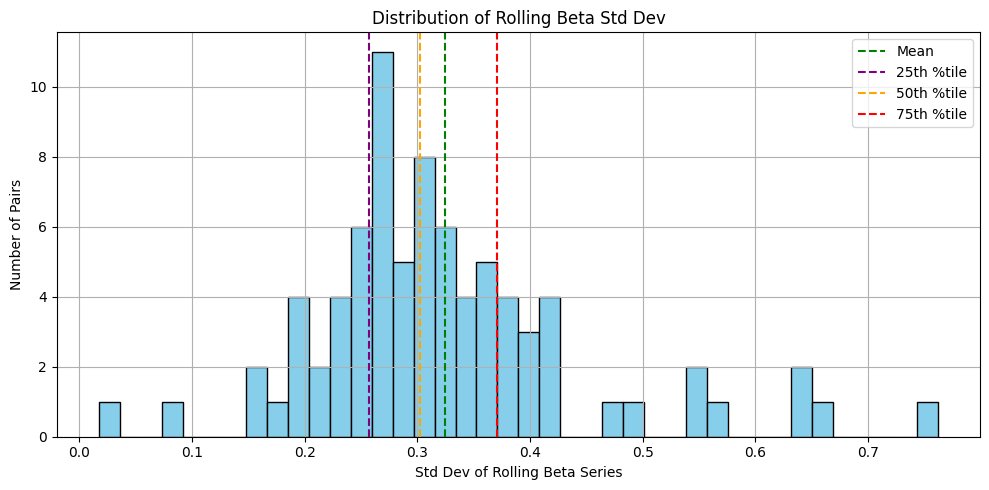

count    80.000000
mean      0.324167
std       0.123145
min       0.017280
25%       0.256895
50%       0.302685
75%       0.370638
max       0.762091
Name: rolling_beta_std, dtype: float64


In [35]:
# Compute std dev of rolling beta for each pair
filtered_pairs_df = filtered_pairs_df.copy()
filtered_pairs_df['rolling_beta_std'] = filtered_pairs_df['rolling_beta_series'].apply(lambda s: s.std())

# Calculate overlay statistics
beta_vol_25 = filtered_pairs_df['rolling_beta_std'].quantile(0.25)
beta_vol_mean = filtered_pairs_df['rolling_beta_std'].mean()
beta_vol_median = filtered_pairs_df['rolling_beta_std'].median()
beta_vol_75 = filtered_pairs_df['rolling_beta_std'].quantile(0.75)

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(filtered_pairs_df['rolling_beta_std'], bins=40, color='skyblue', edgecolor='black')
plt.axvline(beta_vol_mean, color='green', linestyle='--', label='Mean')
plt.axvline(beta_vol_25, color='purple', linestyle='--', label='25th %tile')
plt.axvline(beta_vol_median, color='orange', linestyle='--', label='50th %tile')
plt.axvline(beta_vol_75, color='red', linestyle='--', label='75th %tile')
plt.title("Distribution of Rolling Beta Std Dev")
plt.xlabel("Std Dev of Rolling Beta Series")
plt.ylabel("Number of Pairs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(filtered_pairs_df['rolling_beta_std'].describe())

#### Beta Stability Threshold Selection

The histogram above displays the distribution of the standard deviations of rolling beta series across all remaining candidate pairs.

The distribution is slightly skewed right with a few high-volatility outliers. To strike a balance between conservativeness and breadth, I selected the **50th percentile** (median) as the filtering threshold. This ensures that only the most stable half of the pairs are retained for final consideration, aligning with the strategy’s emphasis on robustness and structural consistency.

This threshold will also be used in <code>src/risk.py</code>, stored as <code>RiskModel.BETA_VOL_THRESHOLD</code>, to filter out trade signals for pairs whose beta is unstable on a rolling window.

In [37]:
# Compute 50th percentile threshold
beta_std_threshold = np.percentile(filtered_pairs_df['rolling_beta_std'], 50)

# Filter pairs
stable_beta_df = filtered_pairs_df[filtered_pairs_df['rolling_beta_std'] <= beta_std_threshold].reset_index(drop=True)
filtered_out_df = filtered_pairs_df[filtered_pairs_df['rolling_beta_std'] > beta_std_threshold].reset_index(drop=True)

print(f"Selected {len(stable_beta_df)} pairs with stable beta (<= {beta_std_threshold:.4f})")

# Sort by stability (lowest std first)
stable_beta_df = stable_beta_df.sort_values(by='rolling_beta_std').reset_index(drop=True)
filtered_out_df = filtered_out_df.sort_values(by='rolling_beta_std').reset_index(drop=True)
display(stable_beta_df[['ticker1', 'ticker2', 'rolling_beta_std']].head())

Selected 40 pairs with stable beta (<= 0.3027)


,ticker1,ticker2,rolling_beta_std
0,GOOG,GOOGL,0.017280
1,PAA,PAGP,0.088261
2,CTRA,AR,0.157861
3,CTRA,CRK,0.163282
4,SHO,HST,0.182716


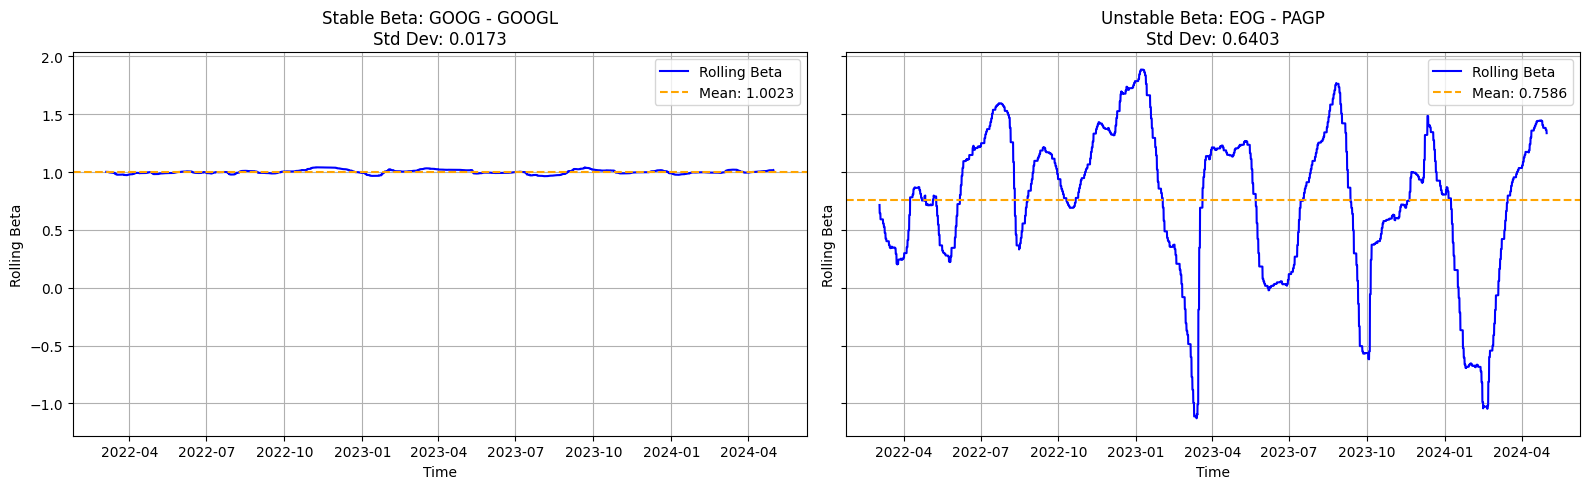

In [38]:
# Choose one high performer and one unstable beta pair
high_row = stable_beta_df.iloc[0]
low_row = filtered_out_df.iloc[-3]

# Subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Helper plotting function
def plot_rolling_beta(ax, row, title):
    beta_series = row['rolling_beta_series'].dropna()
    ax.plot(beta_series.index, beta_series, label='Rolling Beta', color='blue')
    ax.axhline(beta_series.mean(), color='orange', linestyle='--', label=f'Mean: {beta_series.mean():.4f}')
    ax.set_title(f"{title}: {row['ticker1']} - {row['ticker2']}\nStd Dev: {beta_series.std():.4f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Rolling Beta")
    ax.grid(True)
    ax.legend()

# Plot both
plot_rolling_beta(axes[0], high_row, "Stable Beta")
plot_rolling_beta(axes[1], low_row, "Unstable Beta")

plt.tight_layout()
plt.show()

#### **Rolling Beta Visualization: Stable vs. Unstable Pairs**

The plots above compare the rolling hedge ratio (beta) stability of two contrasting pairs.

- The **left panel** shows the beta series of **GOOG - GOOGL**, a highly stable pair with a rolling beta standard deviation of **0.0173**. The beta remains tightly anchored near its long-run average, indicating consistent co-movement and structural robustness—desirable traits for constructing reliable spreads.

- The **right panel** depicts the beta series of **EOG - PAGP**, an unstable pair with a standard deviation of **0.6403**. This pair exhibits persistent swings and regime shifts in its hedge ratio, increasing the risk of poor spread formation, misalignment, and exposure to unintended directional risk.

This comparison highlights the importance of **beta stability filtering** in statistical arbitrage. Pairs with volatile betas may yield unreliable spread behavior and deteriorate strategy performance due to unstable risk profiles.

---
### **Final Summary**

Through a rigorous and multi-stage statistical filtering process - including correlation screening, cointegration testing, mean-reversion validation, half-life analysis, and beta stability assessment - we have distilled a large initial universe of candidate pairs into a refined selection of **40 high-quality trading pairs**.

These pairs exhibit the structural and statistical characteristics necessary to support a robust mean-reversion strategy, including strong co-integration relationships, consistent spread behavior, and stable hedge ratios. This curated universe now serves as the foundation for strategy development, backtesting, and execution.

I saved the final list of pairs in <code>data/final_pairs.csv</code> and a dataframe of final pairs along with their filtration metrics in <code>data/final_pair_metrics.csv</code> for reproducibility and later use.

In [39]:
# From stable_beta_df
beta_metrics = stable_beta_df[['ticker1', 'ticker2', 'correlation', 'coint_pval', 'rolling_beta_std']]

# From adf_pairs_df
adf_metrics = adf_pairs_df[['ticker1', 'ticker2', 'adf_stat']]

# From hurst_pairs_df
hurst_metrics = hurst_pairs_df[['ticker1', 'ticker2', 'hurst']]

# From filtered_pairs_df
filtered_pairs_df = filtered_pairs_df[['ticker1', 'ticker2', 'half_life_days']]

# Merge all three on ticker1 and ticker2
final_pair_metrics_df = (
    beta_metrics
    .merge(adf_metrics, on=['ticker1', 'ticker2'], how='inner')
    .merge(hurst_metrics, on=['ticker1', 'ticker2'], how='inner')
    .merge(filtered_pairs_df, on=['ticker1', 'ticker2'], how='inner')
)

# Reorder columns for readability
final_pair_metrics_df = final_pair_metrics_df[['ticker1', 'ticker2', 'correlation', 'coint_pval', 'adf_stat',
                                                'half_life_days', 'hurst', 'rolling_beta_std']]

# Save statically
final_pair_metrics_df.to_csv(os.path.join(data_dir, "final_pair_metrics.csv"), index=False)
final_pair_metrics_df[['ticker1', 'ticker2']].to_csv(os.path.join(data_dir, "final_pairs.csv"), index=False)